In [37]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt

In [38]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [39]:
customer_transactions = pd.merge(transactions, customers, on="CustomerID", how="inner")
customer_aggregated = customer_transactions.groupby("CustomerID").agg({
    "TotalValue": "sum",                # Total spending
    "TransactionID": "count",           # Number of transactions
    "Quantity": "sum"                   # Total quantity purchased
}).reset_index()

customer_aggregated.columns = ["CustomerID", "TotalSpend", "TransactionCount", "TotalQuantity"]
customer_data = pd.merge(customers, customer_aggregated, on="CustomerID", how="inner")


In [40]:
# Feature engineering
customer_data["SignupDate"] = pd.to_datetime(customer_data["SignupDate"])
customer_data["AccountAge"] = (datetime.now() - customer_data["SignupDate"]).dt.days
customer_data["RegionEncoded"] = customer_data["Region"].astype("category").cat.codes

# Select features and scale
features = ["RegionEncoded", "AccountAge", "TotalSpend", "TransactionCount", "TotalQuantity"]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[features])

# K-Means Clustering

In [41]:
db_scores = []
silhouette_scores = []

# Running K-Means for cluster numbers from 2 to 10 as given in the task
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)

    db_index = davies_bouldin_score(scaled_features, clusters)
    silhouette_avg = silhouette_score(scaled_features, clusters)

    db_scores.append((k, db_index))
    silhouette_scores.append((k, silhouette_avg))
    print(f"K-Means | Clusters: {k}, DB Index: {db_index:.4f}, Silhouette Score: {silhouette_avg:.4f}")

K-Means | Clusters: 2, DB Index: 1.2779, Silhouette Score: 0.2987
K-Means | Clusters: 3, DB Index: 1.4398, Silhouette Score: 0.2197
K-Means | Clusters: 4, DB Index: 1.2426, Silhouette Score: 0.2348
K-Means | Clusters: 5, DB Index: 1.3140, Silhouette Score: 0.2443
K-Means | Clusters: 6, DB Index: 1.2497, Silhouette Score: 0.2512
K-Means | Clusters: 7, DB Index: 1.1218, Silhouette Score: 0.2596
K-Means | Clusters: 8, DB Index: 1.2031, Silhouette Score: 0.2538
K-Means | Clusters: 9, DB Index: 1.1719, Silhouette Score: 0.2401
K-Means | Clusters: 10, DB Index: 1.1439, Silhouette Score: 0.2414


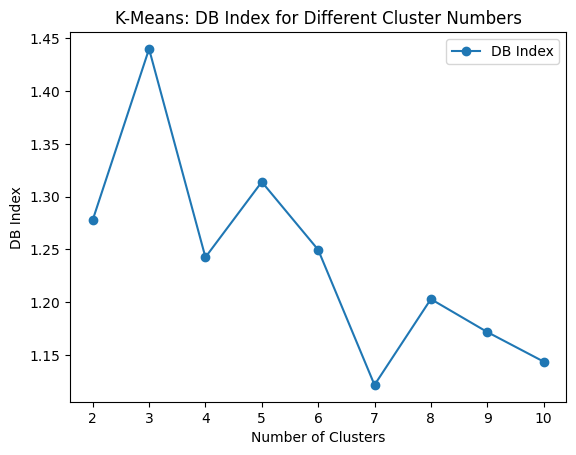

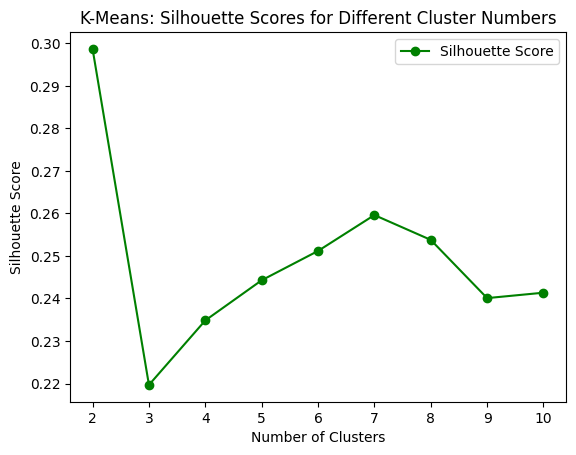

In [42]:
k_values, db_values = zip(*db_scores)
silhouette_values = [score[1] for score in silhouette_scores]

plt.plot(k_values, db_values, marker='o', label="DB Index")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.title("K-Means: DB Index for Different Cluster Numbers")
plt.legend()
plt.show()

plt.plot(k_values, silhouette_values, marker='o', label="Silhouette Score", color='green')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("K-Means: Silhouette Scores for Different Cluster Numbers")
plt.legend()
plt.show()

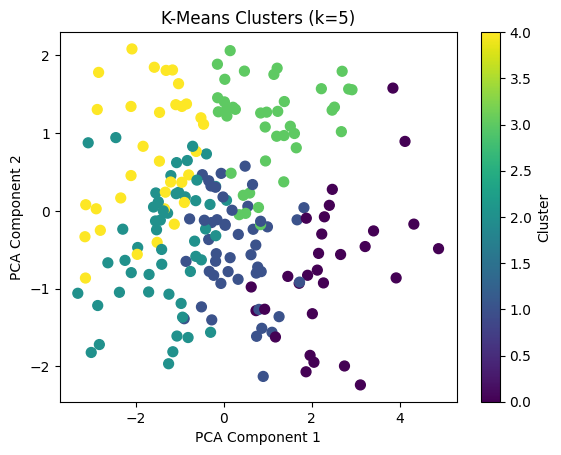

In [43]:
# Visualize optimal K-Means clusters (using 5 clusters as an example)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap="viridis", s=50)
plt.title(f"K-Means Clusters (k={optimal_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

# DBSCAN Clustering

In [44]:

dbscan = DBSCAN(eps=1.6, min_samples=5)  # Adjust `eps` and `min_samples` as needed
clusters = dbscan.fit_predict(scaled_features)

# Evaluate DBSCAN
db_index = davies_bouldin_score(scaled_features, clusters)
silhouette_avg = silhouette_score(scaled_features, clusters)
print(f"DBSCAN | DB Index: {db_index:.4f}, Silhouette Score: {silhouette_avg:.4f}")

DBSCAN | DB Index: 0.6527, Silhouette Score: 0.3822


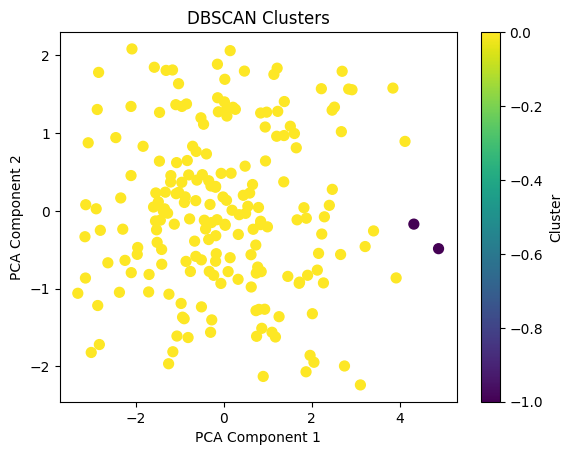

In [45]:
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap="viridis", s=50)
plt.title("DBSCAN Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

# Gaussian Mixture Model (GMM)

In [46]:
gmm = GaussianMixture(n_components=5, random_state=42)
clusters = gmm.fit_predict(scaled_features)

# Evaluate GMM
db_index = davies_bouldin_score(scaled_features, clusters)
silhouette_avg = silhouette_score(scaled_features, clusters)
print(f"GMM | DB Index: {db_index:.4f}, Silhouette Score: {silhouette_avg:.4f}")

GMM | DB Index: 2.0535, Silhouette Score: 0.1470


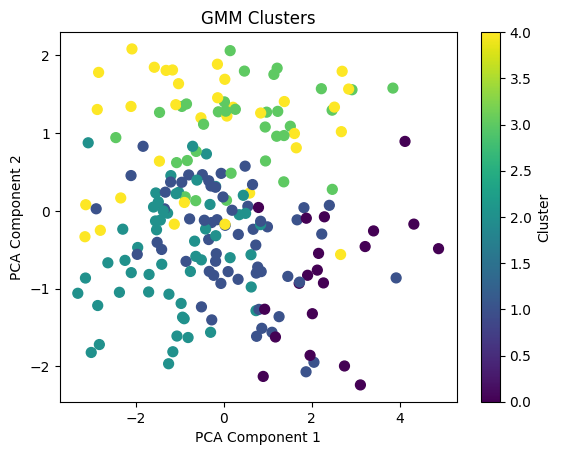

In [47]:
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap="viridis", s=50)
plt.title("GMM Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

# Hierarchical Clustering

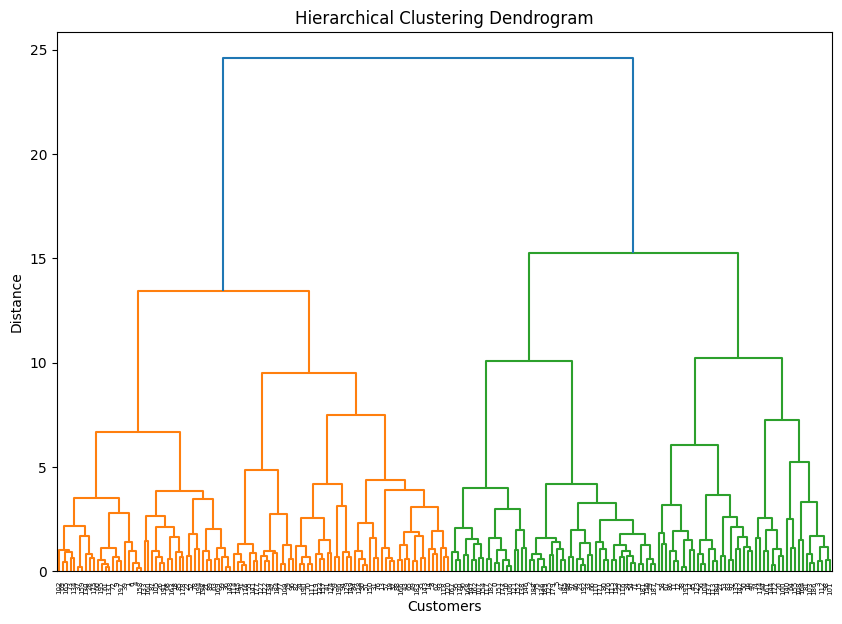

In [48]:
linkage_matrix = linkage(scaled_features, method="ward")
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Customers")
plt.ylabel("Distance")
plt.show()

Hierarchical Clustering | DB Index: 1.4151, Silhouette Score: 0.1929


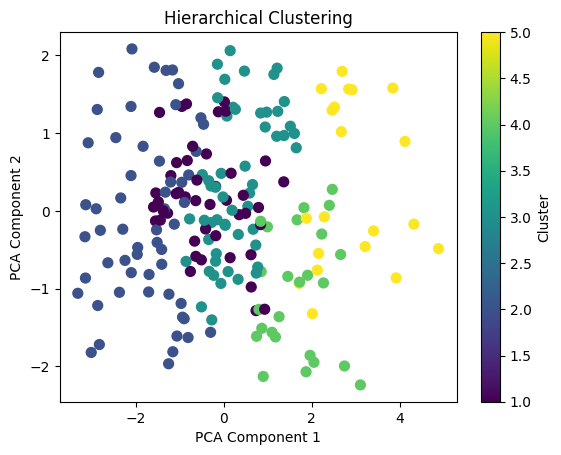

In [49]:

clusters = fcluster(linkage_matrix, t=5, criterion="maxclust")

# Evaluate Hierarchical Clustering
db_index = davies_bouldin_score(scaled_features, clusters)
silhouette_avg = silhouette_score(scaled_features, clusters)
print(f"Hierarchical Clustering | DB Index: {db_index:.4f}, Silhouette Score: {silhouette_avg:.4f}")

# Visualize hierarchical clusters
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap="viridis", s=50)
plt.title("Hierarchical Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()
